# Задача 

Для  расчета  тепловой  схемы  простой ГТУ  заданы  или  приняты  по  оценке  следующие  исходные величины:
* электрическая мощность Nэ = 100 МВт
* температура газов перед турбиной tc = 1200 °С
* температура воздуха на входе в компрессор ta = 15 °С
* отношение давлений компрессора ε = pb/pa = 16
* коэффициент потерь давления λ = δ/ε = 0,95
* коэффициент  использования  теплоты  топлива  в камере сгорания ηк.c = 0,995
* механический КПД турбины ηм = 0,995
* КПД электрического генератора ηэ.г = 0,982
* изоэнтропийный КПД турбины ηт = 0,88
* изоэнтропийный КПД компрессора ηк = 0,8

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append("..")
from natural_gas.gas import NaturalGas, NaturalGasVolumetric

In [3]:
kPa = 1e3
MPa = 1e6
MW = 1e6

to_kelvin = lambda x: x + 273.15
to_celsius = lambda x: x - 273.15

In [124]:
electrical_power = 100 * MW
T_c = to_kelvin(1200)
T_a = to_kelvin(15)
p_a = 101 * kPa
pressure_loss_coefficient = 0.95
compression_factor = 16


combustor_efficiency = 0.995
mechanical_efficiency = 0.995
generator_efficiency = 0.982
compressor_efficiency = 0.86
turbine_efficiency = 0.88

R_air = 287
# m_air = 0.28

gtu_efficiency = 0.35
gas_mass_flow_rate = 275.2045683974156
fuel_density = 0.669

air_density = p_a / (287 * T_a)
rho = fuel_density / air_density

In [125]:
gas = NaturalGasVolumetric(1)
air = NaturalGas(1)

In [126]:
fuel_volumetric_flow_rate = electrical_power / (gtu_efficiency * gas.net_calorific_value * 1000)
fuel_mass_flow_rate = fuel_volumetric_flow_rate * fuel_density
air_mass_flow_rate = gas_mass_flow_rate - fuel_mass_flow_rate

In [127]:
left = (gas_mass_flow_rate / (fuel_density * fuel_volumetric_flow_rate)) - 1
right = fuel_density / (1.293 * gas.air_v0)
alpha = left*right
alpha

2.748139121006315

In [128]:
L0 = gas.air_v0 / rho
Q_lower = gas.net_calorific_value * 1000 / fuel_density 
m_air = R_air / air._cp_air(T_a)
h_a = air.h_air(T_a)

In [129]:
T_b = T_a * (1 + (compression_factor ** m_air - 1) / compressor_efficiency)
print("Температура за компрессором в первом приближении: ", to_celsius(T_b))

Температура за компрессором в первом приближении:  420.68132642074943


In [130]:
h_b = air.h_air(T_b)
cp_air_mean = (h_b - h_a) / (T_b - T_a) 
m_air_precise = R_air / cp_air_mean
m_air_precise

0.27856065860225204

In [131]:
T_b = T_a * (1 + (compression_factor ** m_air_precise - 1) / compressor_efficiency)
h_b = air.h_air(T_b)
print("Температура за компрессором:", to_celsius(T_b))

Температура за компрессором: 405.28019049905345


In [133]:
h_c = (
    gas.h_cp(T_c, alpha=alpha) * 1000 *
    fuel_volumetric_flow_rate / gas_mass_flow_rate
)

h_c

1782110.8309047108

In [134]:
m_gas = 0.25

In [135]:
expansion_ratio = compression_factor * pressure_loss_coefficient
expansion_ratio

15.2

In [136]:
T_d = T_c * (1 - (1 - expansion_ratio ** (-m_gas)) * turbine_efficiency)
print("Температура за турбиной в первом приближении: ", to_celsius(T_d))

Температура за турбиной в первом приближении:  560.1794204434805


In [137]:
h_d = (
    1000 * gas.h_cp(T_d, alpha) *
    fuel_volumetric_flow_rate / gas_mass_flow_rate
)

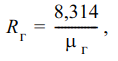

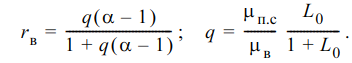

In [138]:
nu_ccp = 8.313 / gas.R_cp * 1000
nu_air = 29

In [139]:
q = (nu_ccp * L0) / (nu_air * (1 + L0))
r_frac = q * (alpha - 1) / (1 + q * (alpha - 1))
nu_gas = nu_air * r_frac + nu_ccp * (1 - r_frac)
R_gas = 8.314 * 1000 / nu_gas
R_gas

292.5998542306131

In [140]:
Cp_gas = (h_c - h_d) / (T_c - T_d)
m_gas = R_gas / Cp_gas
m_gas

0.23010277762624717

In [141]:
T_d = T_c * (1 - (1 - expansion_ratio ** (-m_gas)) * turbine_efficiency)
print("Температура за турбиной: ", to_celsius(T_d))

Температура за турбиной:  596.7092499216686


In [142]:
h_d = (
    1000 * gas.h_cp(T_d, alpha) *
    fuel_volumetric_flow_rate / gas_mass_flow_rate
)

In [143]:
H_turbine = h_c - h_d
H_compressor = h_b - h_a
H_work = H_turbine * mechanical_efficiency - (air_mass_flow_rate / gas_mass_flow_rate) * H_compressor

In [144]:
gas_mass_flow = electrical_power / (H_work * generator_efficiency)
gas_mass_flow

275.3987157965226

In [145]:
turbine_power = gas_mass_flow_rate * H_turbine
compressor_power = air_mass_flow_rate * H_compressor

In [146]:
work_coefficient = (turbine_power - compressor_power) / turbine_power
work_coefficient

0.48695188998936134

In [147]:
electrical_efficiency_estimated = (
    gas_mass_flow_rate * H_work * generator_efficiency / (fuel_mass_flow_rate * Q_lower)
)
electrical_efficiency_estimated

0.3497532610510149